# Framework for maximizing accuracy under the constraint that average utility for the population is above a certain threshold

Import necessary dependencies.
Note that the modules "load_compas_data_modified", "utils" and "funcs_disp_mist_modified" are adopted from "Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment" by Zafar et. al.

In [4]:
import numpy as np
import pandas as pd
from load_compas_data_modified  import *
import funcs_disp_mist_modified as fdm
import matplotlib.pyplot as plt
import utils_modified as ut
from cvxpy import *
import ncvx
from scsprox import Prox

### Defining a utility function

In [5]:
# this complies with the cvxpy framework that we use to optimize
# but it doesn't give back a number
def avg_utility(y_pred, y_actual,alpha):
    #assert(y_pred.shape[0] == y.shape[0])
    n = y_actual.shape[0]
    s = sum_entries(power(((y_pred-y_actual)+10),alpha))
    return s/n 

# this is essentially the same function but it can't be used with the cvxpy framework
# we use this one when we need to produce a number as an output
def eval_util(y_pred, y_actual, alpha):
    n = y_actual.shape[0]
    s = sum(np.power((np.subtract(y_pred,y_actual)+10),alpha))
    return s/n 

In [7]:
## sanity check for utility function here
print(eval_util(np.array([2,2,-2,-2]),np.array([1,1,-1,-1]),1))

10.0


## toy example

this is used for debugging purposes and sanity checks

In [4]:
X_toy = np.matrix('1 1;-1 1;1 2;-1 2')
y_toy = np.array([1, 1, -1, -1])


w = fdm.train_model_disp_mist(X_toy, y_toy, None, "logreg", 1e-6, None)

y_pred = np.asarray(np.dot(X_toy,w)).reshape(-1)

alpha = 1
EPS = 1e-6
max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

w_cons = Variable(2)
w_cons.value = np.random.rand(2)

# threshold that average utility needs to be above, called epsilon in the plots  
threshold = 2
y_pred = (X_toy*w_cons)

util = avg_utility(y_pred, y_toy, alpha)
constraints = []
constraints.append(threshold <= util)
#constraints.append(threshold <= np.sum(np.subtract(np.sign(np.dot(x_train, w)), y_train)/2)/y_train.shape[0])

loss = sum_entries(logistic( mul_elemwise(-y_toy, X_toy*w_cons) )  ) / 4

prob = Problem(Minimize(loss), constraints)

tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

try:
    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver=ECOS, verbose=False, 
            feastol=EPS, abstol=EPS, reltol=EPS,feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
            max_iters=max_iters, max_iter=max_iter_dccp)
except Exception as e:
    print (e)

print(w_cons.value)
w_cons = np.array(w_cons.value).flatten()

print(w_cons)
print(np.asarray(np.dot(X_toy,w_cons)).reshape(-1))
util_cons = eval_util(np.asarray(np.dot(X_toy,w_cons)).reshape(-1), y_toy, alpha)
print(util_cons)

[[  7.06161321e-12]
 [ -4.19611953e-01]]
[  7.06161321e-12  -4.19611953e-01]
[-0.41961195 -0.41961195 -0.83922391 -0.83922391]
9.37058207068


## Importing the COMPAS dataset

Here we import the COMPAS dataset. It is preprocessed the same way as in the ProPublica study (refer to https://github.com/propublica/compas-analysis)

In [8]:
#data_type = 1
X, y, x_control = load_compas_data()

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory..

Number of people recidivating within two years
-1    2795
 1    2483
dtype: int64


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree'] 



this is some code to save the imported dataset in a matlab compatible format

In [35]:
#import scipy.io

#scipy.io.savemat('/Users/claudioferrari/Desktop/Compas_X.mat', mdict={'arr': X})
#scipy.io.savemat('/Users/claudioferrari/Desktop/Compas_y.mat', mdict={'arr': y})

## Train the utility model

In [22]:
"""permute the data randomly"""
perm = list(range(0,X.shape[0]))
shuffle(perm)
X = X[perm]
y = y[perm]
#for k in list(x_control.keys()):
for k in x_control.keys():
    x_control[k] = x_control[k][perm]

""" Split the data into train and test """
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

(3695, 8)
(1583, 8)


In [21]:
# a list of all sensitive attributes, in the case of the COMPAS dataset it's only 'race'
sensitive_attrs = list(x_control.keys())


# set the alpha parameter for our utility function
alpha = -100

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6 # tolerance parameter for the optimizer
loss_function = "logreg" # perform the experiments with logistic regression

num_points, num_features = x_train.shape

# initialize a random value of the weight vectors
w_uncons = Variable(num_features)
w_uncons.value = np.random.rand(x_train.shape[1])
w_cons = Variable(num_features)
w_cons.value = np.random.rand(x_train.shape[1])

# train an unconstrained classifier
w_uncons = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)


train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_uncons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

util_uncons = eval_util((np.dot(x_train, w_uncons)), y_train,alpha)
print("Utility without constraints: " + str(util_uncons) + "\n")

        
# threshold that average utility needs to be above, called epsilon in the plots  
threshold = 1
y_pred = (x_train*w_cons)

# logistic loss
loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

util = avg_utility(y_pred, y_train, alpha)

# constraints for our optimization
# w constrained element-wise to not allow arbitrary utlity increase by scaling w
constraints = [threshold <= util, w_cons <= 10]

prob = Problem(Minimize(loss), constraints)

tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

try:
    prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver=ECOS, verbose=False,
            max_iters=max_iters, max_iter=max_iter_dccp)
except Exception as e:
    print (e)

#convert solution vector to a numpy array
w_cons = np.array(w_cons.value).flatten()

# achieved utility of constrained classifier
util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

print("Utility with constraints: " + str(util_cons) + "\n")
print(np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points)

[ 1.  1. -1. ... -1.  1.  1.]


Accuracy: 0.664
||  s  || FPR. || FNR. ||
||  0  || 0.33 || 0.32 ||
||  1  || 0.20 || 0.60 ||


Utility without constraints: 2.03906279230103e-90

[ 1.  1.  1. ... -1.  1.  1.]


Accuracy: 0.657
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.32 ||
||  1  || 0.18 || 0.61 ||


Utility with constraints: 166.40381621177266

0.8642140717487573


### Let's see how our solution fares w.r.t. other fairness notions

In [7]:
# need to split predictions into different groups
# for demographic parity, only need to look at positive prediction percentage of the two groups
# group 1 is white, group 0 is black

# we look at the outcome in the test set

y_pred = np.sign(np.dot(x_test,w_cons))

y_pred_uncons = np.sign(np.dot(x_test, w_uncons))


group_array = x_control_test['race']

# total number of data points
n = y_test.shape[0]
unique, counts = np.unique(group_array, return_counts=True)
# number of people in group 0
n0 = counts[0]
# number of people in group 1
n1 = counts[1]

#print(n)
#print(n0)
#print(n1)

print("\n" +"############ Let's look at demographic parity ##############")

# positive prediction count for both classes and for both true labels and predicted labels
pos_count0_actual = 0
pos_count1_actual = 0 
pos_count0_pred = 0
pos_count1_pred = 0
pos_count0_pred_uncons = 0
pos_count1_pred_uncons = 0

counter = 0
for group_membership in group_array:
    if group_membership == 1:
        if y_test[counter] == 1:
            pos_count1_actual += 1
        if y_pred[counter] == 1:
            pos_count1_pred += 1
        if y_pred_uncons[counter] == 1:
            pos_count1_pred_uncons += 1
    elif group_membership == 0:
        if y_test[counter] == 1:
            pos_count0_actual += 1
        if y_pred[counter] == 1:
            pos_count0_pred += 1
        if y_pred_uncons[counter] == 1:
            pos_count0_pred_uncons += 1
    else:
        print("ERROR")
    counter += 1

print("Positive percentage actual in group 1: " + str(pos_count1_actual/n1))
             
print("Positive percentage actual in group 0: " + str(pos_count0_actual/n0))

print("Positive percentage predicted in group 1(constrained): " + str(pos_count1_pred/n1))
        
print("Positive percentage predicted in group 0(constrained): " + str(pos_count0_pred/n0))

print("Positive percentage predicted in group 1(unconstrained): " + str(pos_count1_pred_uncons/n1))
        
print("Positive percentage predicted in group 0(unconstrained): " + str(pos_count0_pred_uncons/n0))


print("\n" +"############ Let's look at equality of opportunity ##############")

pos_count0_pred = 0
pos_count1_pred = 0
pos_count0_pred_uncons = 0
pos_count1_pred_uncons = 0

counter = 0
for group_membership in group_array:
    if group_membership == 1:
        if y_test[counter] == 1:
            if y_pred[counter] == 1:
                pos_count1_pred += 1
            if y_pred_uncons[counter] == 1:
                pos_count1_pred_uncons += 1
    elif group_membership == 0:
        if y_test[counter] == 1:
            if y_pred[counter] == 1:
                pos_count0_pred += 1
            if y_pred_uncons[counter] == 1:
                pos_count0_pred_uncons += 1
    else:
        print("ERROR")
    counter += 1
    
print("Positive percentage predicted in group 1(constrained): " + str(pos_count1_pred/pos_count1_actual))
        
print("Positive percentage predicted in group 0(constrained): " + str(pos_count0_pred/pos_count0_actual))

print("Positive percentage predicted in group 1(unconstrained): " + str(pos_count1_pred_uncons/pos_count1_actual))
        
print("Positive percentage predicted in group 0(unconstrained): " + str(pos_count0_pred_uncons/pos_count0_actual))


############ Let's look at demographic parity ##############
Positive percentage actual in group 1: 0.3786008230452675
Positive percentage actual in group 0: 0.5230219043361645
Positive percentage predicted in group 1(constrained): 0.887517146776406
Positive percentage predicted in group 0(constrained): 0.981671881984801
Positive percentage predicted in group 1(unconstrained): 0.27434842249657065
Positive percentage predicted in group 0(unconstrained): 0.5149754135002235

############ Let's look at equality of opportunity ##############
Positive percentage predicted in group 1(constrained): 0.9565217391304348
Positive percentage predicted in group 0(constrained): 0.9931623931623932
Positive percentage predicted in group 1(unconstrained): 0.40217391304347827
Positive percentage predicted in group 0(unconstrained): 0.6794871794871795


### DP and EO with varying epsilon

In [24]:
# group 1 is white, group 0 is black

# we look at the outcome in the test set



sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
threshold_iter = 30
# how many cross validation iterations
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 0

# array of all threshold values to try, range needs to be specified such that on the lower end
#  the classifier behaves as if unconstrained and on the upper end it has to classify all data points
#  positively
threshold_array = np.linspace(2,6,threshold_iter)
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(threshold_iter)
loss_array = np.zeros(threshold_iter)
# holds percentages of positive predictions for both groups w.r.t. demographic parity
pc0_DP_array = np.zeros(threshold_iter)
pc1_DP_array = np.zeros(threshold_iter)
# holds percentages of positive predictions for both groups w.r.t. equality of opportunity
pc0_EO_array = np.zeros(threshold_iter)
pc1_EO_array = np.zeros(threshold_iter)


for j in range(0,threshold_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    threshold = threshold_array[j]
    
    accuracy = 0
    l = 0
    pc0_DP = 0
    pc1_DP = 0
    pc0_EO = 0
    pc1_EO = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape
    

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        util = avg_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        
        group_array = x_control_test['race']
        # total number of data points
        n = y_test.shape[0]
        unique, counts = np.unique(group_array, return_counts=True)
        # number of people in group 0
        n0 = counts[0]
        # number of people in group 1
        n1 = counts[1]
        
        y_pred = np.sign(np.dot(x_test,w_cons))
        
        # positive prediction count for both classes and for predicted labels
        pos_count0_actual = 0
        pos_count1_actual = 0 
        pos_count0_pred = 0
        pos_count1_pred = 0

        # demographic parity check
        counter = 0
        for group_membership in group_array:
            if group_membership == 1:
                if y_test[counter] == 1:
                    pos_count1_actual += 1
                if y_pred[counter] == 1:
                    pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    pos_count0_actual += 1
                if y_pred[counter] == 1:
                    pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1


        
        pc0_DP += pos_count0_pred/n0
        pc1_DP += pos_count1_pred/n1
        
        pos_count0_pred = 0
        pos_count1_pred = 0
        
        # equality of opportunity check
        counter = 0
        for group_membership in group_array:
            if group_membership == 1:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1
        
        pc0_EO += pos_count0_pred/pos_count0_actual
        pc1_EO += pos_count1_pred/pos_count1_actual
        
        
    accuracy_array[j] = accuracy / cross_val_iter
    loss_array[j] = l / cross_val_iter
    pc0_DP_array[j] = pc0_DP / cross_val_iter
    pc1_DP_array[j] = pc1_DP / cross_val_iter
    pc0_EO_array[j] = pc0_EO / cross_val_iter
    pc1_EO_array[j] = pc1_EO / cross_val_iter
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[-1. -1. -1. ..., -1. -1.  1.]


Accuracy: 0.660
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.32 ||
||  1  || 0.17 || 0.61 ||


#############cross validation iteration 1 #########################
None
[-1. -1.  1. ..., -1.  1. -1.]


Accuracy: 0.670
||  s  || FPR. || FNR. ||
||  0  || 0.34 || 0.32 ||
||  1  || 0.19 || 0.57 ||


#############cross validation iteration 2 #########################
None
[ 1. -1. -1. ...,  1.  1. -1.]


Accuracy: 0.675
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.29 ||
||  1  || 0.15 || 0.61 ||


#############cross validation iteration 3 #########################
None
[ 1.  1. -1. ..., -1. -1. -1.]


Accuracy: 0.659
||  s  || FPR. || FNR. ||
||  0  || 0.32 || 0.35 ||
||  1  || 0.17 || 0.62 ||


#############cross validation iteration 4 #########################
None
[-1.  1.  1. ..., -1. -1.  1.]


Accuracy: 0.667
|| 

[-1. -1. -1. ...,  1.  1. -1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.27 ||
||  1  || 0.16 || 0.62 ||


#############cross validation iteration 1 #########################
None
[-1. -1.  1. ...,  1. -1. -1.]


Accuracy: 0.670
||  s  || FPR. || FNR. ||
||  0  || 0.39 || 0.27 ||
||  1  || 0.13 || 0.64 ||


#############cross validation iteration 2 #########################
None
[-1. -1.  1. ..., -1. -1. -1.]


Accuracy: 0.661
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.30 ||
||  1  || 0.18 || 0.61 ||


#############cross validation iteration 3 #########################
None
[-1. -1.  1. ...,  1.  1. -1.]


Accuracy: 0.660
||  s  || FPR. || FNR. ||
||  0  || 0.40 || 0.28 ||
||  1  || 0.14 || 0.66 ||


#############cross validation iteration 4 #########################
None
[-1.  1.  1. ..., -1.  1.  1.]


Accuracy: 0.657
||  s  || FPR. || FNR. ||
||  0  || 0.31 || 0.36 ||
||  1  || 0.14 || 0.67 ||


########Test accuracy: 3.3174560216508793 (for threshold iterat



#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.516
||  s  || FPR. || FNR. ||
||  0  || 0.95 || 0.02 ||
||  1  || 0.83 || 0.05 ||


#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.517
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.02 ||
||  1  || 0.83 || 0.04 ||


#############cross validation iteration 3 #########################
None
[-1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.526
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.02 ||
||  1  || 0.78 || 0.07 ||


#############cross validation iteration 4 #########################
None
[ 1.  1. -1. ...,  1. -1.  1.]


Accuracy: 0.522
||  s  || FPR. || FNR. ||
||  0  || 0.92 || 0.02 ||
||  1  || 0.79 || 0.06 ||


########Test accuracy: 2.5880920162381598 (for threshold iteration) 14 ############

#############Threshold value iteration 15 #########################
#############cross validation iterati

[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.483
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.95 || 0.01 ||


#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.485
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.95 || 0.01 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.478
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.95 || 0.01 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.479
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.95 || 0.01 ||


########Test accuracy: 2.4043301759133966 (for threshold iteration) 21 ############

#############Threshold value iteration 22 #########################
#############cross validation iteration 0 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accura



#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.471
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.466
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.99 || 0.01 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.465
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


########Test accuracy: 2.3534506089309875 (for threshold iteration) 28 ############

#############Threshold value iteration 29 #########################
#############cross validation iteration 0 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.468
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iterati

### DP and EO with varying alpha

In [31]:
# need to split predictions into different groups
# for demographic parity, only need to look at positive prediction percentage of the two groups
# group 1 is white, group 0 is black

# we look at the outcome in the test set



sensitive_attrs = list(x_control.keys())

# how many equispaced alpha values to try within the range specified later 
alpha_iter = 30
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0
# specify range for alpha parameters to try
alpha_array = np.linspace(0.45,1,alpha_iter)


# set the alpha parameter for our utility
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 5
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(alpha_iter)
loss_array = np.zeros(alpha_iter)
# holds percentages of positive predictions for both groups w.r.t. demographic parity
pc0_DP_array = np.zeros(alpha_iter)
pc1_DP_array = np.zeros(alpha_iter)
# holds percentages of positive predictions for both groups w.r.t. equality of opportunity
pc0_EO_array = np.zeros(alpha_iter)
pc1_EO_array = np.zeros(alpha_iter)


for j in range(0,alpha_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    alpha = alpha_array[j]
    
    accuracy = 0
    l = 0
    pc0_DP = 0
    pc1_DP = 0
    pc0_EO = 0
    pc1_EO = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape
    

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        util = avg_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        accuracy += test_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        
        group_array = x_control_test['race']
        # total number of data points
        n = y_test.shape[0]
        unique, counts = np.unique(group_array, return_counts=True)
        # number of people in group 0
        n0 = counts[0]
        # number of people in group 1
        n1 = counts[1]
        
        y_pred = np.sign(np.dot(x_test,w_cons))
        
        # positive prediction count for both classes and for predicted labels
        pos_count0_actual = 0
        pos_count1_actual = 0 
        pos_count0_pred = 0
        pos_count1_pred = 0

        # demographic parity check
        counter = 0
        for group_membership in group_array:
            if group_membership == 1:
                if y_test[counter] == 1:
                    pos_count1_actual += 1
                if y_pred[counter] == 1:
                    pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    pos_count0_actual += 1
                if y_pred[counter] == 1:
                    pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1


        
        pc0_DP += pos_count0_pred/n0
        pc1_DP += pos_count1_pred/n1
        
        pos_count0_pred = 0
        pos_count1_pred = 0
        
        # equality of opportunity check
        counter = 0
        for group_membership in group_array:
            if group_membership == 1:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count1_pred += 1
            elif group_membership == 0:
                if y_test[counter] == 1:
                    if y_pred[counter] == 1:
                        pos_count0_pred += 1
            else:
                print("ERROR")
            counter += 1
        
        pc0_EO += pos_count0_pred/pos_count0_actual
        pc1_EO += pos_count1_pred/pos_count1_actual
        
        
    accuracy_array[j] = accuracy / cross_val_iter
    loss_array[j] = l / cross_val_iter
    pc0_DP_array[j] = pc0_DP / cross_val_iter
    pc1_DP_array[j] = pc1_DP / cross_val_iter
    pc0_EO_array[j] = pc0_EO / cross_val_iter
    pc1_EO_array[j] = pc1_EO / cross_val_iter
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.478
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.471
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 2 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.471
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 3 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.474
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.471
|| 

[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.526
||  s  || FPR. || FNR. ||
||  0  || 0.98 || 0.00 ||
||  1  || 0.76 || 0.07 ||


#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.534
||  s  || FPR. || FNR. ||
||  0  || 0.92 || 0.02 ||
||  1  || 0.78 || 0.05 ||


#############cross validation iteration 2 #########################
None
[-1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.540
||  s  || FPR. || FNR. ||
||  0  || 0.89 || 0.03 ||
||  1  || 0.77 || 0.07 ||


#############cross validation iteration 3 #########################
None
[-1. -1.  1. ...,  1.  1.  1.]


Accuracy: 0.556
||  s  || FPR. || FNR. ||
||  0  || 0.90 || 0.03 ||
||  1  || 0.59 || 0.18 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.512
||  s  || FPR. || FNR. ||
||  0  || 0.94 || 0.02 ||
||  1  || 0.82 || 0.06 ||


########Test accuracy: 2.6679296346414074 (for threshold iterat



#############cross validation iteration 1 #########################
None
[ 1.  1.  1. ..., -1. -1. -1.]


Accuracy: 0.670
||  s  || FPR. || FNR. ||
||  0  || 0.34 || 0.31 ||
||  1  || 0.14 || 0.64 ||


#############cross validation iteration 2 #########################
None
[ 1.  1. -1. ..., -1.  1. -1.]


Accuracy: 0.666
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.31 ||
||  1  || 0.17 || 0.57 ||


#############cross validation iteration 3 #########################
None
[ 1. -1.  1. ..., -1. -1.  1.]


Accuracy: 0.658
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.31 ||
||  1  || 0.18 || 0.61 ||


#############cross validation iteration 4 #########################
None
[-1.  1. -1. ..., -1. -1. -1.]


Accuracy: 0.668
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.28 ||
||  1  || 0.13 || 0.66 ||


########Test accuracy: 3.3179972936400537 (for threshold iteration) 14 ############

#############Threshold value iteration 15 #########################
#############cross validation iterati

[-1.  1. -1. ...,  1.  1.  1.]


Accuracy: 0.670
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.29 ||
||  1  || 0.20 || 0.55 ||


#############cross validation iteration 2 #########################
None
[-1. -1.  1. ...,  1. -1. -1.]


Accuracy: 0.663
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.31 ||
||  1  || 0.15 || 0.63 ||


#############cross validation iteration 3 #########################
None
[-1. -1. -1. ...,  1.  1. -1.]


Accuracy: 0.663
||  s  || FPR. || FNR. ||
||  0  || 0.25 || 0.42 ||
||  1  || 0.18 || 0.59 ||


#############cross validation iteration 4 #########################
None
[ 1. -1.  1. ..., -1.  1.  1.]


Accuracy: 0.668
||  s  || FPR. || FNR. ||
||  0  || 0.23 || 0.42 ||
||  1  || 0.20 || 0.55 ||


########Test accuracy: 3.3169147496617053 (for threshold iteration) 21 ############

#############Threshold value iteration 22 #########################
#############cross validation iteration 0 #########################
None
[-1.  1. -1. ...,  1. -1.  1.]


Accura



#############cross validation iteration 2 #########################
None
[-1. -1.  1. ..., -1. -1.  1.]


Accuracy: 0.668
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.31 ||
||  1  || 0.20 || 0.54 ||


#############cross validation iteration 3 #########################
None
[-1.  1. -1. ..., -1. -1. -1.]


Accuracy: 0.663
||  s  || FPR. || FNR. ||
||  0  || 0.38 || 0.29 ||
||  1  || 0.16 || 0.61 ||


#############cross validation iteration 4 #########################
None
[ 1.  1.  1. ..., -1.  1. -1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.29 ||
||  1  || 0.15 || 0.62 ||


########Test accuracy: 3.319621109607578 (for threshold iteration) 28 ############

#############Threshold value iteration 29 #########################
#############cross validation iteration 0 #########################
None
[-1. -1. -1. ..., -1.  1.  1.]


Accuracy: 0.673
||  s  || FPR. || FNR. ||
||  0  || 0.33 || 0.32 ||
||  1  || 0.13 || 0.64 ||


#############cross validation iteratio

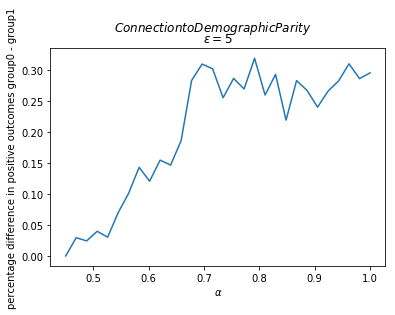

In [32]:
# we plot how the difference in positive predictions between groups changes as we vary alpha or epsilon
# demographic parity first
plt.plot(alpha_array, np.subtract(pc0_DP_array,pc1_DP_array))
plt.suptitle('$Connection to Demographic Parity$')
plt.title('$\epsilon = 5$')
plt.ylabel('percentage difference in positive outcomes group0 - group1')
plt.xlabel('$\\alpha$')
plt.show()

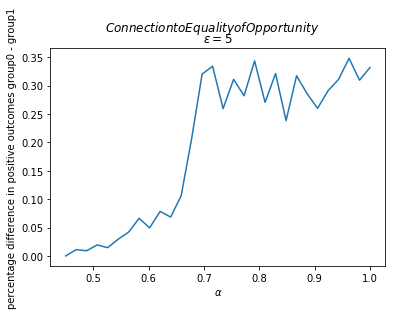

In [42]:
# we plot how the difference in positive predictions between groups changes as we vary alpha or epsilon
# equality of opportunity (meaning positive predictions conditioned on the actual label being positive)
plt.plot(alpha_array, np.subtract(pc0_EO_array,pc1_EO_array))
plt.suptitle('$Connection to Equality of Opportunity$')
plt.title('$\epsilon = 5$')
plt.ylabel('percentage difference in positive outcomes group0 - group1')
plt.xlabel('$\\alpha$')
plt.show()

## implementation with cross validation for varying epsilon

Notes: 
    - utility for unconstrained is around 9.98 (for alpha = 1)
    - for alpha=1 the scanned region of thresholds was 9-40
    - for alpha=0.5 it was 3-5
    - w element-wise constrained to be smaller equal 10

In [14]:
sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
threshold_iter = 20
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0.5

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 0
# array of all threshold values to try, range needs to be specified such that on the lower end
#  the classifier behaves as if unconstrained and on the upper end it has to classify all data points
#  positively
threshold_array = np.linspace(3,6,threshold_iter)
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(threshold_iter)
loss_array = np.zeros(threshold_iter)

for j in range(0,threshold_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    threshold = threshold_array[j]
    
    accuracy = 0
    l = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        util = avg_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()


        util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        print(test_score)
        accuracy += train_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        print("Utility with constraints: " + str(util_cons) + "\n")
    accuracy = accuracy / cross_val_iter
    l = l / cross_val_iter
    accuracy_array[j] = accuracy
    loss_array[j] = l
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[-1.  1. -1. ...  1.  1.  1.]


Accuracy: 0.678
||  s  || FPR. || FNR. ||
||  0  || 0.31 || 0.31 ||
||  1  || 0.17 || 0.58 ||


0.6778269109286166
Utility with constraints: 3.1473193632922034

#############cross validation iteration 1 #########################
None
[ 1.  1. -1. ...  1. -1. -1.]


Accuracy: 0.653
||  s  || FPR. || FNR. ||
||  0  || 0.39 || 0.27 ||
||  1  || 0.18 || 0.68 ||


0.6525584333543903
Utility with constraints: 3.15283640976328

#############cross validation iteration 2 #########################
None
[-1.  1.  1. ... -1. -1.  1.]


Accuracy: 0.669
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.31 ||
||  1  || 0.13 || 0.64 ||


0.6689829437776375
Utility with constraints: 3.151083136105063

#############cross validation iteration 3 #########################
None
[-1. -1. -1. ... -1. -1.  1.]


Accuracy: 0.665
||  s  || FPR. ||

[ 1.  1. -1. ...  1.  1.  1.]


Accuracy: 0.512
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.02 ||
||  1  || 0.84 || 0.05 ||


0.5123183828174352
Utility with constraints: 3.789473684312127

#############cross validation iteration 4 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.514
||  s  || FPR. || FNR. ||
||  0  || 0.95 || 0.01 ||
||  1  || 0.82 || 0.04 ||


0.5142135186355022
Utility with constraints: 3.7894736844151335

########Test accuracy: 0.5178890392422193 (for threshold iteration) 5 ############

#############Threshold value iteration 6 #########################
#############cross validation iteration 0 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.517
||  s  || FPR. || FNR. ||
||  0  || 0.96 || 0.02 ||
||  1  || 0.83 || 0.03 ||


0.5167403663929249
Utility with constraints: 3.947368421281057

#############cross validation iteration 1 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.483
||  s  || FPR. || FNR. 

[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.475
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.96 || 0.01 ||


0.4750473783954517
Utility with constraints: 4.736842106058174

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.476
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.96 || 0.01 ||


0.476310802274163
Utility with constraints: 4.736842106621577

#############cross validation iteration 3 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.483
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.95 || 0.02 ||


0.4826279216677195
Utility with constraints: 4.736842106514599

#############cross validation iteration 4 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.476
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.93 || 0.02 ||


0.4756790903348073
Utility with constraints: 4.7368421063414266

########Test accuracy: 0.480216508795

[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.494
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.96 || 0.00 ||


0.4939987365761213
Utility with constraints: 5.68421052958487

#############cross validation iteration 1 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.474
||  s  || FPR. || FNR. ||
||  0  || 0.99 || 0.00 ||
||  1  || 0.98 || 0.02 ||


0.4737839545167404
Utility with constraints: 5.684210530788078

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.474
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.96 || 0.01 ||


0.4737839545167404
Utility with constraints: 5.684210531700865

#############cross validation iteration 3 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.472
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 0.97 || 0.00 ||


0.4718888186986734
Utility with constraints: 5.684210531135546

#############cross validation iteratio

In [15]:
eps_accuracy = accuracy_array

### Different threshold values without crossvalidaiton and reshuffling

In [83]:
sensitive_attrs = list(x_control.keys())

# how many equispaced threshold values to try within the range specified later 
threshold_iter = 20

# set the alpha parameter for our utility
alpha = 1

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 0
# array of all threshold values to try, range needs to be specified such that on the lower end
#  the classifier behaves as if unconstrained and on the upper end it has to classify all data points
#  positively
threshold_array = np.linspace(5,40,threshold_iter)
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(threshold_iter)
loss_array = np.zeros(threshold_iter)
"""permute the date randomly"""
perm = list(range(0,X.shape[0]))
shuffle(perm)
X = X[perm]
y = y[perm]
#for k in list(x_control.keys()):
for k in x_control.keys():
    x_control[k] = x_control[k][perm]

""" Split the data into train and test """
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

num_points, num_features = x_train.shape

for j in range(0,threshold_iter):
        print("#############Threshold value iteration " + str(j) + " #########################")
        threshold = threshold_array[j]

        accuracy = 0
        l = 0


        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        util = avg_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve()
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()


        util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        print(test_score)
        accuracy += test_score
        print("Utility with constraints: " + str(util_cons) + "\n")
        l = np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        accuracy_array[j] = accuracy
        loss_array[j] = l
        print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
[ 1.  1. -1. ..., -1.  1. -1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.28 ||
||  1  || 0.17 || 0.62 ||


0.6711772665764547
Utility with constraints: 9.9749517123

########Test accuracy: 0.6711772665764547 (for threshold iteration) 0 ############

#############Threshold value iteration 1 #########################
[ 1.  1. -1. ..., -1.  1. -1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.28 ||
||  1  || 0.17 || 0.62 ||


0.6711772665764547
Utility with constraints: 9.97495171236

########Test accuracy: 0.6711772665764547 (for threshold iteration) 1 ############

#############Threshold value iteration 2 #########################
[ 1.  1. -1. ..., -1.  1. -1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.36 || 0.28 ||
||  1  || 0.17 || 0.62 ||


0.6711772665764547
Utility with constraints: 9.97495171239

########Test accuracy: 0.6711772665764547 (for threshold iteratio

/Users/claudioferrari/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:73: RuntimeWarning: overflow encountered in exp


[-1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.364
||  s  || FPR. || FNR. ||
||  0  || 0.75 || 0.51 ||
||  1  || 0.86 || 0.33 ||


0.36427604871447905
Utility with constraints: 50.6842105104

########Test accuracy: 0.36427604871447905 (for threshold iteration) 16 ############

#############Threshold value iteration 17 #########################
[-1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.364
||  s  || FPR. || FNR. ||
||  0  || 0.75 || 0.51 ||
||  1  || 0.86 || 0.33 ||


0.36427604871447905
Utility with constraints: 53.7894736777

########Test accuracy: 0.36427604871447905 (for threshold iteration) 17 ############

#############Threshold value iteration 18 #########################
[-1.  1.  1. ...,  1.  1.  1.]


Accuracy: 0.364
||  s  || FPR. || FNR. ||
||  0  || 0.75 || 0.51 ||
||  1  || 0.86 || 0.33 ||


0.36427604871447905
Utility with constraints: 56.8947368399

########Test accuracy: 0.36427604871447905 (for threshold iteration) 18 ############

#############Threshold value iterati

### Cross validation with varying alpha

In [11]:
sensitive_attrs = list(x_control.keys())

# how many equispaced alpha values to try within the range specified later 
alpha_iter = 10
cross_val_iter = 5

# set the alpha parameter for our utility
alpha = 0
# specify range for alpha parameters to try
alpha_array = np.linspace(0.45,1,alpha_iter)

max_iters = 100 # for the convex program
max_iter_dccp = 50  # for the dccp algo

cons_params = None # constraint parameters, will use them later
EPS = 1e-6
loss_function = "logreg" # perform the experiments with logistic regression

# threshold that average utility needs to be above, called epsilon in the plots 
threshold = 5
# those arrays hold the accuracy and loss values for all iterations
accuracy_array = np.zeros(alpha_iter)
loss_array = np.zeros(alpha_iter)

for j in range(0,alpha_iter):
    print("#############Threshold value iteration " + str(j) + " #########################")
    alpha = alpha_array[j]
    
    accuracy = 0
    l = 0
    for i in range(0,cross_val_iter):
        print(print("#############cross validation iteration " + str(i) + " #########################"))
        """permute the date randomly"""
        perm = list(range(0,X.shape[0]))
        shuffle(perm)
        X = X[perm]
        y = y[perm]
        #for k in list(x_control.keys()):
        for k in x_control.keys():
            x_control[k] = x_control[k][perm]

        """ Split the data into train and test """
        train_fold_size = 0.7
        x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

        num_points, num_features = x_train.shape

        w_cons = Variable(num_features)
        w_cons.value = np.random.rand(x_train.shape[1])

        #logistic loss
        loss = sum_entries(logistic( mul_elemwise(-y_train, x_train*w_cons) )  ) / num_points # we are converting y to a diagonal matrix for consistent

        y_pred = (x_train*w_cons)

        util = avg_utility(y_pred, y_train, alpha)
        
        # constraints for our optimization
        # w constrained element-wise to not allow arbitrary utlity increase by scaling w
        constraints = [threshold <= util, w_cons <= 10]
        
        
        prob = Problem(Minimize(loss), constraints)

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset

        try:
            prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
                    solver=ECOS, verbose=False,
                    max_iters=max_iters, max_iter=max_iter_dccp)
        except Exception as e:
            print (e)


        w_cons = np.array(w_cons.value).flatten()


        util_cons = eval_util((np.dot(x_train, w_cons)), y_train, alpha)

        train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w_cons, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)
        print(test_score)
        accuracy += train_score
        l += np.sum(np.log(1 + np.exp(np.multiply(-y_train, (np.dot(x_train,w_cons)))))) / num_points
        print("Utility with constraints: " + str(util_cons) + "\n")
    accuracy = accuracy / cross_val_iter
    l = l / cross_val_iter
    accuracy_array[j] = accuracy
    loss_array[j] = l
    print("########Test accuracy: " + str(accuracy) + " (for threshold iteration) " + str(j)+ " ############" + "\n")

#############Threshold value iteration 0 #########################
#############cross validation iteration 0 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.466
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


0.4655716993051169
Utility with constraints: 5.0000000182616295

#############cross validation iteration 1 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.461
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


0.46114971572962726
Utility with constraints: 5.000000015957815

#############cross validation iteration 2 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.476
||  s  || FPR. || FNR. ||
||  0  || 1.00 || 0.00 ||
||  1  || 1.00 || 0.00 ||


0.4756790903348073
Utility with constraints: 5.000000013370811

#############cross validation iteration 3 #########################
None
[1. 1. 1. ... 1. 1. 1.]


Accuracy: 0.479
||  s  || FPR. || FNR. ||
||  0  || 1.0

[-1. -1. -1. ...  1. -1. -1.]


Accuracy: 0.671
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.32 ||
||  1  || 0.16 || 0.58 ||


0.6708780795957043
Utility with constraints: 5.671167114834467

#############cross validation iteration 4 #########################
None
[ 1. -1.  1. ...  1. -1.  1.]


Accuracy: 0.668
||  s  || FPR. || FNR. ||
||  0  || 0.37 || 0.32 ||
||  1  || 0.12 || 0.61 ||


0.6677195198989261
Utility with constraints: 5.668382530733881

########Test accuracy: 0.668362652232747 (for threshold iteration) 5 ############

#############Threshold value iteration 6 #########################
#############cross validation iteration 0 #########################
None
[ 1. -1. -1. ... -1.  1. -1.]


Accuracy: 0.680
||  s  || FPR. || FNR. ||
||  0  || 0.35 || 0.28 ||
||  1  || 0.18 || 0.56 ||


0.6803537586860392
Utility with constraints: 6.522515562060064

#############cross validation iteration 1 #########################
None
[-1.  1.  1. ...  1. -1.  1.]


Accuracy: 0.663
||  s  

Now we plot accuracy vs the parameter we are varying (epsilon or alpha)

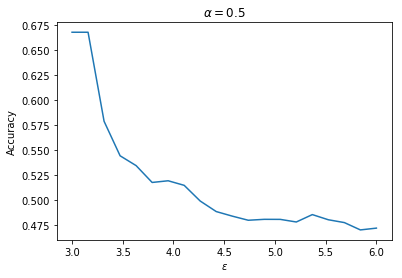

In [16]:
plt.plot(threshold_array, accuracy_array)
plt.title('$\\alpha = 0.5$')
plt.ylabel('Accuracy')
plt.xlabel('$\epsilon$')
plt.show()

In [88]:
print(accuracy_array)
print(loss_array)

[ 0.66641407  0.66863329  0.66506089  0.66181326  0.6702571   0.58890392
  0.58284168  0.58051421  0.58278755  0.58760487  0.56968877  0.53423545
  0.52481732  0.51918809  0.50500677  0.50289581  0.49829499  0.50121786
  0.50533153  0.50565629  0.49596752  0.4947226   0.4861705   0.48774019
  0.48189445  0.48443843  0.47507442  0.48167794  0.47924222  0.47875507]
[  0.61254788   0.62167814   0.61874025   0.62094693   0.61756169
   0.71832334   1.00850381   1.3551441    1.75343353   2.0982469
   2.48732001   3.00264421   3.48780039   3.88781834   4.58151759
   5.04293846   5.67342158   6.40799307   6.68965895   7.48977249
   8.01325668   8.83356152   9.03799171  10.00338752  10.48272315
  11.26720006  11.79794305  12.87483391  13.52467871  14.39686586]
